# Simulate separated-aperture nulling interferometry with PLsim

`PLsim` not only can do mode-based imaging simulations, but also separated-aperture interferometric simulations. This notebook shows how.

Let's first define two apertures

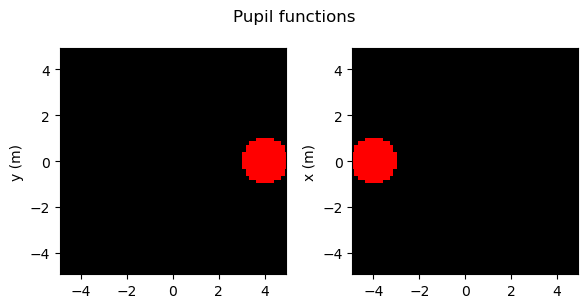

In [51]:
from PLsim.otf import OTF
import hcipy as hc
import numpy as np
import matplotlib.pyplot as plt

# Define pupil grid
ndim = 65
diameter = 10
pupil_grid = hc.make_pupil_grid(ndim, diameter)

ref_wavelength = 1.55e-6

aperture = hc.make_circular_aperture(diameter)(pupil_grid)

mask_locs = [(4, 0), (-4, 0)] # two-hole aperture mask separated by 8m
mask_radius = 1
otf_ami = OTF.from_aperture_masks(mask_locs, mask_radius, pupil_grid)

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
for i in range(2):
    hc.imshow_field(otf_ami.pupil_functions[i], grid = pupil_grid, ax=axs[i])
    axs[i].set_ylabel('x (m)')
fig.suptitle('Pupil functions')
axs[0].set_ylabel('y (m)')
fig.tight_layout()
plt.show()

In [52]:
otf_ami.compute()

Now define a device that has two inputs, which each goes through a Mach-Zehnder interferometer splitting into two outputs, and one of each feeds a tricoupler for nulling. We will define this as an active device: we can modulate phase shifter on-the-fly. This takes defining a function with optional keywords being the phase modulators. See the example below

In [53]:
from PLsim.system.device import Device

# define 2x5 tricoupler device

import PLsim.system.pic as pic

# active device template
def create_active_tricoupler(phase_shift1=0, phase_shift2=0, phase_shift3=np.pi):
    # """Template function for the tricoupler device with adjustable phase shifts."""
    
    # define the input names: I'll say a and b
    device = pic.PIC(['a', 'b'], name="Active Tricoupler")

    # add intensity modulation
    mzi1 = pic.MZI('mzi1', ['a', 'a_monitor'], ['a', 'a_monitor'], phase_shift=phase_shift1)
    device.add_component(mzi1)

    mzi2 = pic.MZI('mzi2', ['b', 'b_monitor'], ['b', 'b_monitor'], phase_shift=phase_shift2)
    device.add_component(mzi2)

    # add phase shift
    ps3 = pic.PhaseShifter('ps3', ['b'], ['b'], phase_shift=phase_shift3)
    device.add_component(ps3)

    # feed the tricoupler
    tri = pic.TriCoupler('tri1', ['a', 'null', 'b'], ['a', 'null', 'b'])#, custom_phase = np.pi*1.1)
    device.add_component(tri)

    return device

# Create active tricoupler
active_tricoupler = pic.ActivePIC(
    device_template=create_active_tricoupler,
    parameter_names=['phase_shift1', 'phase_shift2', 'phase_shift3'],
    initial_parameters={'phase_shift1': 0, 'phase_shift2': 0, 'phase_shift3': 0},
    name="Active Tricoupler"
)

In [54]:
print(active_tricoupler.output_names)

['a', 'b', 'a_monitor', 'b_monitor', 'null']


In [55]:
mode_sorter_transfer_matrix = np.eye(2)[np.newaxis,:] # just 1:1 mapping
device_pic = Device(mode_sorter_transfer_matrix, pic_device=active_tricoupler, port_mapping=[(0,0), (1,1)],
                    verbose =False)

Define the scene object and on-axis point source

In [56]:
from PLsim.scene import Scene, SceneProjector
scene = Scene(pupil_grid, ref_wavelength)
scene_projector = SceneProjector(otf_ami, scene)

point_onaxis = scene_projector.compute_point(0,0)
out_onaxis = device_pic.calculate_outputs(point_onaxis)

The initial configuration sends all the light to photometric channels (a_monitor, b_monitor)

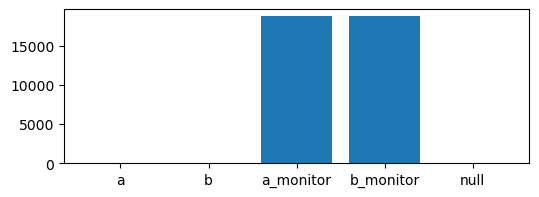

In [57]:
plt.figure(figsize=(6,2))
plt.bar(range(5), out_onaxis[0,:,0])
plt.xticks(range(5), active_tricoupler.output_names)
plt.show()

Now send all the light to the tricoupler

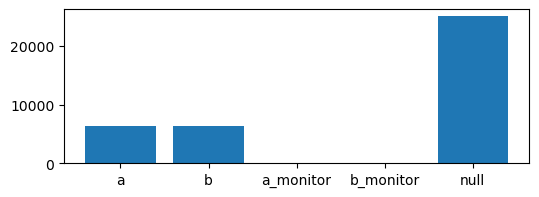

In [58]:
device_pic.update_pic_matrix(phase_shift1=np.pi, phase_shift2=np.pi, phase_shift3=0)
out_onaxis = device_pic.calculate_outputs(point_onaxis)
plt.figure(figsize=(6,2))
plt.bar(range(5), out_onaxis[0,:,0])
plt.xticks(range(5), active_tricoupler.output_names)
plt.show()

Let's null the null output. apply $\pi$ phase shift to the phase_shift3, the phase shifter before the tricoupler in one of the arms

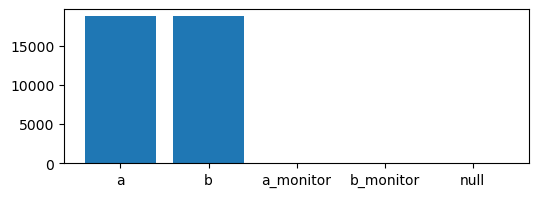

In [59]:
device_pic.update_pic_matrix(phase_shift1=np.pi, phase_shift2=np.pi, phase_shift3=np.pi)
out_onaxis = device_pic.calculate_outputs(point_onaxis)
plt.figure(figsize=(6,2))
plt.bar(range(5), out_onaxis[0,:,0])
plt.xticks(range(5), active_tricoupler.output_names)
plt.show()

We can actually do fringe tracking with the tricoupler. Let's compute the outputs as a function of tilt in $x$, with this phase shifter configuration.

In [73]:
x_locs = np.linspace(-20e-3/206265, 20e-3/206265, 21) # -20 - 20 mas grid
point_1dgrid = []
for x_loc in x_locs:
    point_1dgrid.append(scene_projector.compute_point(x_loc,0))
point_1dgrid = np.array(point_1dgrid)[:,:,:,0].transpose(1,2,0)

In [ ]:
out_1dgrid = device_pic.calculate_outputs(point_1dgrid)

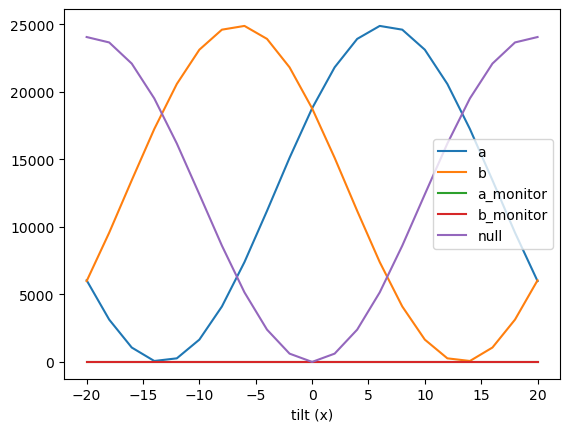

In [81]:
for i in range(5):plt.plot(x_locs*206265e3, out_1dgrid[0][i], label = active_tricoupler.output_port_names[i])
plt.legend()
plt.xlabel('tilt (x)')
plt.show()

Let's now simulate the planet signal. 

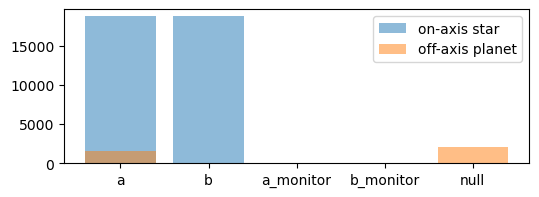

In [87]:
planet_sep = 15e-3/206265 # 15 mas
planet_contrast = 1e-1 

out_onaxis = device_pic.calculate_outputs(point_onaxis)

point_offaxis = scene_projector.compute_point(planet_sep,0) 
out_offaxis = device_pic.calculate_outputs(point_offaxis) * planet_contrast
plt.figure(figsize=(6,2))
plt.bar(range(5), out_onaxis[0,:,0], alpha=0.5, label='on-axis star')
plt.bar(range(5), out_offaxis[0,:,0], alpha=0.5, label='off-axis planet')
plt.xticks(range(5), active_tricoupler.output_names)
plt.legend()
plt.show()